In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

OUTPUT_FILENAME = 'results_mp_d0.5.dat'
NEURAL_NETWORK_FILENAME = 'convmodrecnets_mp_0.5.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers import Input, concatenate
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt


# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return [modules, phases]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
iq_signals = dataset_df[iq_signals_column_dataframe_name].tolist()
mp_signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(iq_signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

iq_signals = np.array(iq_signals)
mp_signals = np.array(mp_signals)

iq_train = iq_signals[train_index]
iq_test =  iq_signals[test_index]

mp_train = mp_signals[train_index]
mp_test =  mp_signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
iq_shape = iq_train.shape
mp_shape = mp_train.shape
print(iq_shape)
print(mp_shape)
iq_shape = list(iq_shape[1:])
mp_shape = list(mp_shape[1:])

classes = mods

(154000, 2, 128)
(154000, 2, 128)


In [16]:
iq_in = keras.Input(shape=iq_shape, name="IQ")
iq_reshape = Reshape([1] + list(iq_shape))(iq_in)
iq_zeropadding1 = ZeroPadding2D((0,2))(iq_reshape)
iq_conv1 = Convolution2D(256, 1, 3, padding="same", activation="relu", name="iq_conv1")(iq_zeropadding1)
iq_dropout1 = Dropout(DROPOUT_RATE)(iq_conv1)
iq_zeropadding2 = ZeroPadding2D((0,2))(iq_dropout1)
iq_conv2 = Convolution2D(80, 2, 3, padding="same", activation="relu", name="iq_conv2")(iq_zeropadding2)
iq_dropout2 = Dropout(DROPOUT_RATE)(iq_conv2)

In [17]:
mp_in = keras.Input(shape=mp_shape, name="MP")
mp_reshape = Reshape([1] + list(mp_shape))(mp_in)
mp_zeropadding1 = ZeroPadding2D((0,2))(mp_reshape)
mp_conv1 = Convolution2D(256, 1, 3, padding="same", activation="relu", name="mp_conv1")(mp_zeropadding1)
mp_dropout1 = Dropout(DROPOUT_RATE)(mp_conv1)
mp_zeropadding2 = ZeroPadding2D((0,2))(mp_dropout1)
mp_conv2 = Convolution2D(80, 2, 3, padding="same", activation="relu", name="mp_conv2")(mp_zeropadding2)
mp_dropout2 = Dropout(DROPOUT_RATE)(mp_conv2)

In [18]:
x = concatenate([iq_conv2, mp_conv2])
flat = Flatten()(x)
dense1 = Dense(256, activation='relu', name="dense1")(flat)
dropout = Dropout(DROPOUT_RATE)(dense1)
dense2 = Dense(len(classes), name="dense2")(dropout)
act = Activation('softmax')(dense2)
output = Reshape([len(classes)])(act)

model = keras.Model(inputs=[iq_in, mp_in], outputs=[output])

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IQ (InputLayer)                 [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
MP (InputLayer)                 [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 2, 128)    0           IQ[0][0]                         
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 2, 128)    0           MP[0][0]                         
______________________________________________________________________________________________

### Train the model

In [19]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    (iq_train, mp_train),
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=((iq_test, mp_test), Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
151/151 [==============================] - 17s 15ms/step - loss: 2.2774 - val_loss: 2.0063
Epoch 2/100
151/151 [==============================] - 2s 12ms/step - loss: 2.0248 - val_loss: 1.8631
Epoch 3/100
151/151 [==============================] - 2s 12ms/step - loss: 1.8860 - val_loss: 1.7814
Epoch 4/100
151/151 [==============================] - 2s 12ms/step - loss: 1.8251 - val_loss: 1.7286
Epoch 5/100
151/151 [==============================] - 2s 12ms/step - loss: 1.7837 - val_loss: 1.6982
Epoch 6/100
151/151 [==============================] - 2s 12ms/step - loss: 1.7622 - val_loss: 1.6819
Epoch 7/100
151/151 [==============================] - 2s 12ms/step - loss: 1.7400 - val_loss: 1.6720
Epoch 8/100
151/151 [==============================] - 2s 12ms/step - loss: 1.7327 - val_loss: 1.6556
Epoch 9/100
151/151 [==============================] - 2s 12ms/step - loss: 1.7159 - val_loss: 1.6488
Epoch 10/100
151/151 [==============================] - 2s 12ms/step - loss: 1.71

151/151 [==============================] - 2s 12ms/step - loss: 1.5469 - val_loss: 1.5562
Epoch 81/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5454 - val_loss: 1.5529
Epoch 82/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5442 - val_loss: 1.5625
Epoch 83/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5415 - val_loss: 1.5534
Epoch 84/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5408 - val_loss: 1.5517
Epoch 85/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5456 - val_loss: 1.5570
Epoch 86/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5393 - val_loss: 1.5535
Epoch 87/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5382 - val_loss: 1.5530
Epoch 88/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5392 - val_loss: 1.5542
Epoch 89/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5379 - 

# Evaluate and Plot Model Performance

In [20]:
# Show simple version of performance
score = model.evaluate((iq_test, mp_test), Y_test, batch_size=BATCH_SIZE)
print(score)

65/65 [==============================] - 0s 4ms/step - loss: 1.5517
1.5517051219940186


## Loss

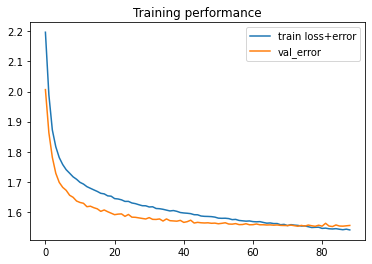

In [21]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [22]:
test_Y_predictions = model.predict((iq_test, mp_test), batch_size=BATCH_SIZE)

test_Y_predictions_length = len(test_Y_predictions)
test_Y_onehotted = []

for i in range(0, test_Y_predictions_length - 1):
    # creating a [0...0] vector
    onehotted_prediction = np.zeros(len(classes))
    
    # I have to place a 1 where the probability value is maximum
    onehot_one_index = np.argmax(test_Y_predictions[i])
    onehotted_prediction[onehot_one_index] = 1
    
    test_Y_onehotted.append(onehotted_prediction)

In [23]:
# 11x11 zeros matrix
confusion_matrix = np.zeros((len(classes), len(classes)))

# row = true label, column = predicted label

for i in range(0, test_Y_predictions_length - 1):
    true_label_index = np.argmax(Y_test[i])
    predicted_label_index = np.argmax(test_Y_onehotted[i])
    
    confusion_matrix[true_label_index][predicted_label_index] += 1

softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
# softmax each confusion matrix row
for i in range(0, len(classes)):
    vector_sum = np.sum(confusion_matrix[i])
    
    for j in range(0, len(confusion_matrix[i]) - 1):
        softmaxed_confusion_matrix[i][j] += round(confusion_matrix[i][j]/vector_sum, 2)
    
softmaxed_confusion_matrix

array([[0.17, 0.01, 0.33, 0.  , 0.12, 0.01, 0.01, 0.15, 0.16, 0.03, 0.  ],
       [0.01, 0.66, 0.23, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.03, 0.89, 0.  , 0.03, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.02, 0.34, 0.27, 0.03, 0.01, 0.23, 0.03, 0.03, 0.01, 0.  ],
       [0.07, 0.01, 0.32, 0.  , 0.53, 0.02, 0.  , 0.02, 0.01, 0.01, 0.  ],
       [0.01, 0.03, 0.28, 0.  , 0.05, 0.59, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.01, 0.23, 0.13, 0.04, 0.  , 0.48, 0.04, 0.02, 0.01, 0.  ],
       [0.15, 0.01, 0.21, 0.01, 0.11, 0.01, 0.01, 0.2 , 0.25, 0.04, 0.  ],
       [0.16, 0.01, 0.14, 0.01, 0.12, 0.01, 0.02, 0.22, 0.28, 0.04, 0.  ],
       [0.14, 0.01, 0.32, 0.01, 0.11, 0.01, 0.01, 0.14, 0.16, 0.08, 0.  ],
       [0.01, 0.44, 0.23, 0.  , 0.01, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [24]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

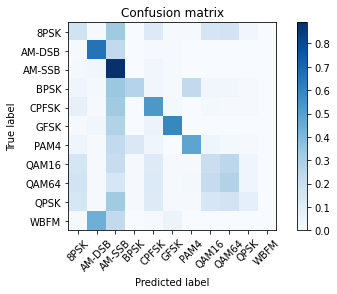

In [25]:
plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes)

## Confusion matrix for each SNR

C:\Users\FALCHE~1\AppData\Local\Temp/ipykernel_1892/1498095756.py:49: RuntimeWarning: invalid value encountered in double_scalars
  perc = confusion_matrix[i][j] / vector_sum


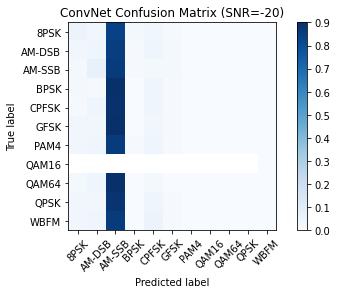

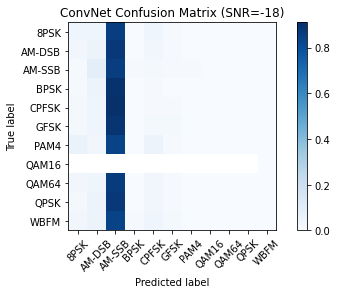

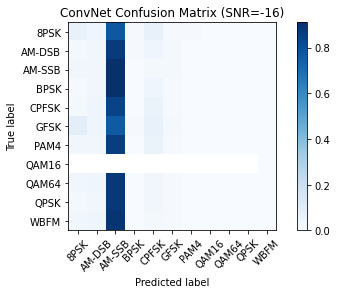

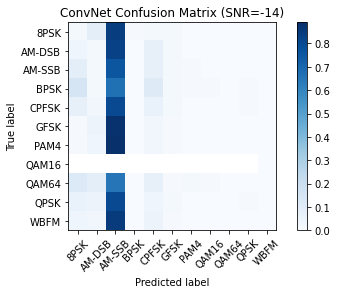

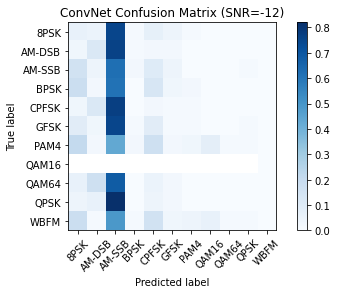

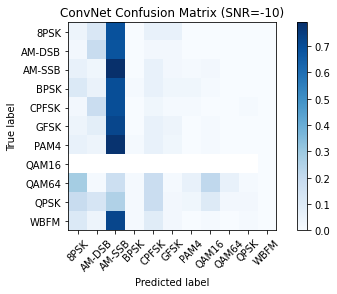

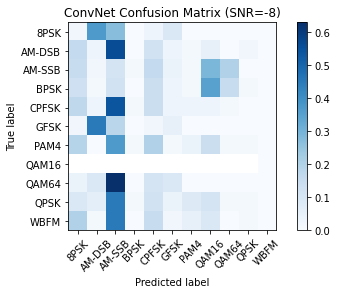

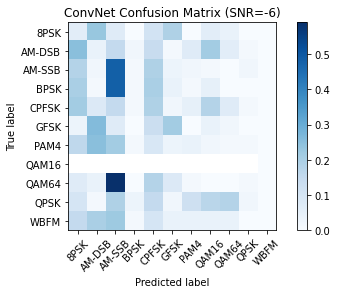

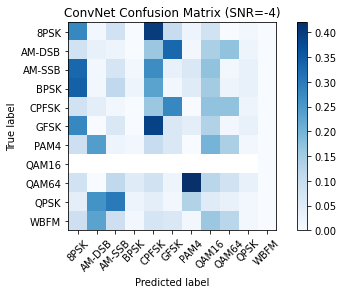

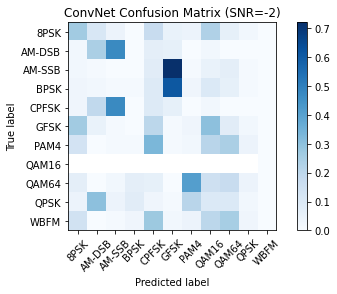

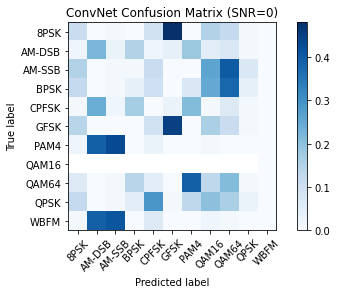

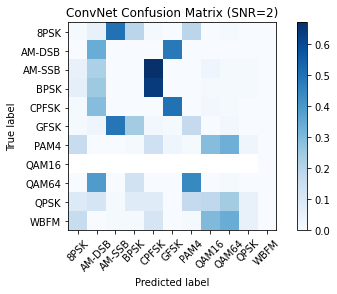

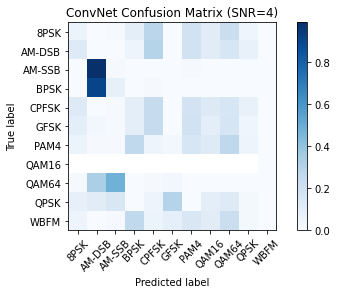

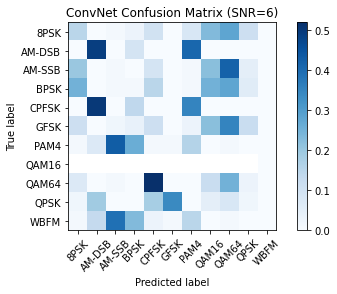

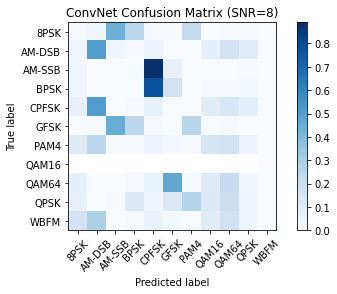

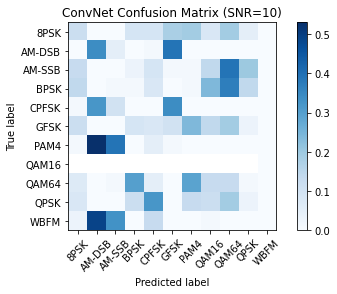

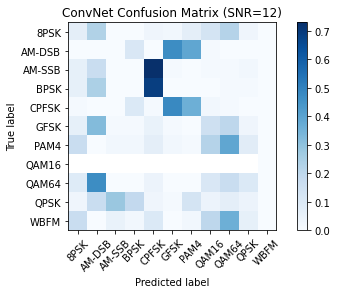

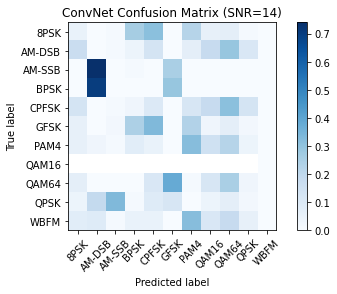

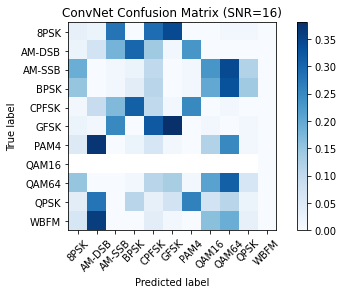

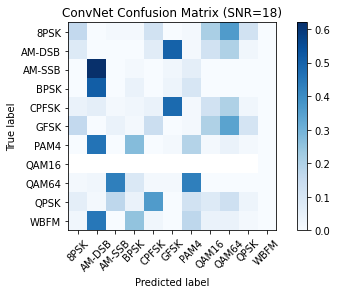

In [26]:
import math

# Plot confusion matrix
acc = {}

for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
        
    test_X_i = (iq_test[this_snr_indexes], mp_test[this_snr_indexes])
    test_Y_i = Y_test[this_snr_indexes]
        
    # estimate classes
    test_Y_predictions = model.predict(test_X_i, batch_size=BATCH_SIZE)
    
    test_Y_predictions_length = len(test_Y_predictions)
    test_Y_onehotted = []
    
    for i in range(0, test_Y_predictions_length - 1):
        # creating a [0...0] vector
        onehotted_prediction = np.zeros(len(classes))

        # I have to place a 1 where the probability value is maximum
        onehot_one_index = np.argmax(test_Y_predictions[i])
        onehotted_prediction[onehot_one_index] = 1

        test_Y_onehotted.append(onehotted_prediction)
            
    # 11x11 zeros matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    # row = true label, column = predicted label

    for i in range(0, test_Y_predictions_length - 1):
        true_label_index = np.argmax(Y_test[i])
        predicted_label_index = np.argmax(test_Y_onehotted[i])

        confusion_matrix[true_label_index][predicted_label_index] += 1

    softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
    # softmax each confusion matrix row
    for i in range(0, len(classes)):
        vector_sum = np.sum(confusion_matrix[i])

        for j in range(0, len(confusion_matrix[i]) - 1):
            perc = confusion_matrix[i][j] / vector_sum
            softmaxed_confusion_matrix[i][j] += round(perc, 2)
    
    plt.figure()
    plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    well_predicted = np.sum(np.diag(confusion_matrix))
    all_predictions = np.sum(confusion_matrix)
    
    acc[snr] = well_predicted / all_predictions

## Accuracy performance

In [27]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,6,6,7,5,6,7,3,9,7,7,10,4,5,10,9,7,3,7,9,4


In [28]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

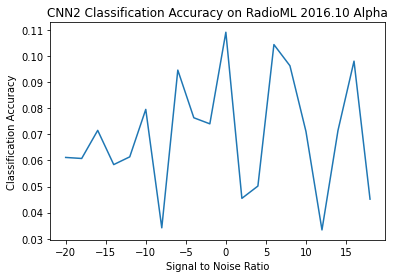

In [29]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")